In [1]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import tensorflow as tf
from sopt.examples.utils import PtychographySimulation
from sopt.examples.tensorflow.far_field_ptychography.tfPtycho import CurveballPhaseRetriever, AdamPhaseRetriever

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def runSteps(pr_obj, n_steps, ptsim, 
             validation_frequency=1, #epochs
             improvement_threshold=5e-4, 
             patience=50, #epochs
             patience_increase=1.5,
             print_frequency=10): #epochs
    errors = np.array([])
    losses = np.array([])
    validation_losses = np.array([])
    validation_best_loss = np.inf
    epoch = 0
    for i in tqdm(range(n_steps)):
        lossval, _ = pr_obj.session.run([pr_obj.training_loss_tensor, pr_obj.obj_minimize_op])
        losses = np.append(losses, lossval)

        if i % (pr_obj._train_ndiffs // pr_obj._batch_size) != 0: 
            continue

        epoch += 1
        #if epoch >= patience:
        #    break
        if epoch >= patience:
            break

        if epoch % validation_frequency != 0:
            continue

        recons_obj_padded = pr_obj.session.run(pr_obj._tf_obj_padded_cmplx)
        recons_obj = recons_obj_padded[40:-40, 40:-40]
        shift, err, phase = register_translation(recons_obj, ptsim._obj_true, upsample_factor=10)
        shift, err, phase = register_translation(recons_obj * np.exp(-1j * phase), ptsim._obj_true, upsample_factor=10)
        errors = np.append(errors, err)

        validation_loss = pr_obj.session.run(pr_obj.validation_loss_tensor)
        #validation_loss = genValidation(recons_obj_padded)
        validation_losses = np.append(validation_losses, validation_loss)

        #validation_loss = lossval
        if validation_loss < validation_best_loss:

            if np.abs(validation_loss - validation_best_loss) > validation_best_loss * improvement_threshold:
                patience = max(patience, epoch * patience_increase)

            validation_best_loss = validation_loss

        if epoch % print_frequency == 0:
            print(f'{epoch} {lossval:8.7g}, {err:8.7g}, {patience:8.7g}, {validation_loss:8.7g}, {validation_best_loss:8.7g}')
    return losses, errors, validation_losses, validation_best_loss

/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


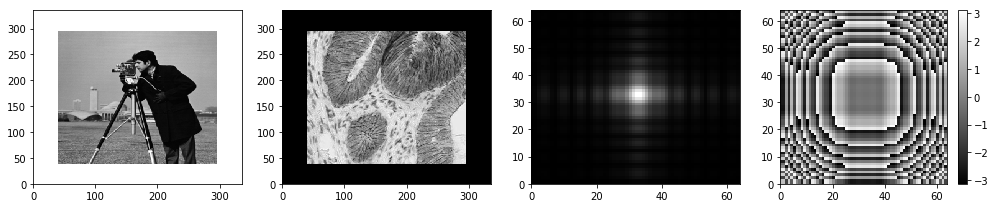

In [4]:
ptsim = PtychographySimulation(positions_step_npix=6, probe_n_photons=1e5)

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax3)
plt.tight_layout()
plt.show()

In [5]:
differences = np.mean([np.random.poisson(ptsim._diffraction_moduli**2) 
                       - ptsim._diffraction_moduli**2
                       for i in range(10)], axis=0)
differences = np.abs(np.fft.fftshift(differences, axes=(1,2)))

In [6]:
class PerturbedAdamPR(AdamPhaseRetriever):
    def __init__(self,*args, **kwargs):
        self._perturb_loaded = False
        super().__init__(*args, **kwargs)
    
    def _load_perturb(self):
        with self.graph.as_default():
            self._train_perturbs = tf.constant(differences[self._train_indices], dtype='float32')
            self._validation_perturbs = tf.reshape(tf.constant(differences[self._validation_indices], dtype='float32'), [-1])
            self._batch_perturbs = tf.reshape(tf.gather(self._train_perturbs, self._batch_indices), [-1])
        
        
    def _getPredictedData(self,
                         obj_flat: tf.Tensor,
                         probe_flat: tf.Tensor,
                         batch_obj_view_indices: tf.Tensor,
                         batch_perturbs: tf.Tensor) -> tf.Tensor:
        
        with self.graph.as_default():
            obj_padded = self._getComplexPaddedObj(obj_flat)
            probe_cmplx = self._getComplexProbe(probe_flat)

            batch_obj_views = tf.gather(tf.reshape(obj_padded, [-1]), batch_obj_view_indices)
            batch_exit_waves = batch_obj_views * probe_cmplx
            batch_farfield_waves = tf.fft2d(batch_exit_waves) / self._ptsim._probe_npix
            batch_guess_mods = tf.reshape(tf.abs(batch_farfield_waves), [-1])
        return tf.sqrt(batch_guess_mods**2 + batch_perturbs)
    
    
    def _getLoss(self, 
                 batch_predictions: tf.Tensor,
                 batch_diff_mods: tf.Tensor,
                 batch_perturbs: tf.Tensor) -> tf.Tensor:
        with self.graph.as_default():
            loss = 0.5 * tf.reduce_sum((batch_predictions - tf.sqrt(batch_diff_mods**2 + batch_perturbs))**2)
        return loss
    
    def _initConvenienceFunctions(self) -> None:
        self._load_perturb()
        self._training_predictions_fn = lambda x, y: self._getPredictedData(x, y, 
                                                                            self._batch_train_obj_view_indices,
                                                                            self._batch_perturbs)
        
        
        self._training_predictions_as_obj_fn = lambda x: self._training_predictions_fn(x, self._tf_probe)
        self._training_predictions_as_probe_fn = lambda x: self._training_predictions_fn(self._tf_obj, x)
        
        self._training_loss_fn = lambda x: self._getLoss(x, self._batch_train_mods, self._batch_perturbs)
        
        
        
        with self.graph.as_default():
            with tf.name_scope('validation'):
                self._validation_predictions_tensor = self._getPredictedData(self._tf_obj, 
                                                                             self._tf_probe,
                                                                             self._validation_view_indices,
                                                                             self._validation_perturbs)
                validation_diff_mods = tf.reshape(self._validation_diff_mods_shifted, [-1])
                self.validation_loss_tensor = self._getLoss(self._validation_predictions_tensor, 
                                                            validation_diff_mods,
                                                            self._validation_perturbs)
    

In [9]:
pr_adam = PerturbedAdamPR(ptsim=ptsim, probe_recons=False, validation_ndiffs=50)
pr_adam.setOptimizingParams()
pr_adam.initSession()

In [10]:
adam_losses, adam_errors, adam_validation_losses, adam_best_validation_loss = runSteps(pr_adam, 10000, ptsim,  
                                                                               improvement_threshold=5e-4,
                                                                               patience_increase=1.5,
                                                                               validation_frequency=100,
                                                                               print_frequency=100,
                                                                               patience=500)

100  1197824, 0.4178358,      500, 32344.82, 32344.82
200 816665.3, 0.3053036,      500, 21468.65, 21468.65
300   782041, 0.2525647,      500, 20285.94, 20285.94
400 771956.2, 0.2202148,      600, 19882.04, 19882.04
500 768181.9, 0.1971047,      750, 19723.03, 19723.03
600   766416, 0.178013,      900, 19642.66, 19642.66
700 765392.6, 0.1611523,     1050, 19591.36, 19591.36
800 764707.2, 0.1460547,     1200, 19554.21, 19554.21
900 764209.6, 0.1326488,     1350, 19525.77, 19525.77
1000 763833.7, 0.1209549,     1500, 19503.57, 19503.57
1100   763545, 0.1109861,     1650, 19486.23, 19486.23
1200 763323.5, 0.1027134,     1800,  19472.8,  19472.8
1300 763154.8, 0.096052,     1950, 19462.55, 19462.55
1400 763028.4, 0.09086241,     1950, 19454.82, 19454.82
1500 762935.4, 0.08695953,     1950, 19449.18, 19449.18
1600 762868.5, 0.08413057,     1950,    19445,    19445
1700 762821.6, 0.08215759,     1950, 19442.13, 19442.13
1800 762789.7, 0.08083629,     1950, 19440.11, 19440.11
1900 762768.6, 0

In [11]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, probe_recons=False, validation_ndiffs=50)
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [12]:
cb_losses, cb_errors, cb_validation_losses, cb_best_validation_loss = runSteps(pr_cb, 10000, ptsim, 
                                                                               improvement_threshold=5e-4,
                                                                               patience_increase=1.5,
                                                                               validation_frequency=10,
                                                                               print_frequency=10,
                                                                               patience=50)

10 914877.1, 0.2608537,       50, 22648.55, 22648.55
20 866648.8, 0.1845801,       50, 20494.05, 20494.05
30 860658.1, 0.1215235,       50, 20199.27, 20199.27
40 858287.1, 0.09466445,       60, 20077.99, 20077.99
50 857325.2, 0.09955522,       75, 20042.33, 20042.33
60 856879.8, 0.09519494,       90, 20029.51, 20029.51
70 856670.8, 0.08457491,       90, 20020.81, 20020.81
80   856442, 0.07121207,       90, 20018.53, 20018.53


In [13]:
pr_adam = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, validation_ndiffs=50)
pr_adam.setOptimizingParams()
pr_adam.initSession()

In [14]:
adam_losses, adam_errors, adam_validation_losses, adam_best_validation_loss = runSteps(pr_adam, 10000, ptsim,  
                                                                               improvement_threshold=5e-4,
                                                                               patience_increase=1.5,
                                                                               validation_frequency=100,
                                                                               print_frequency=100,
                                                                               patience=1000)

100  1340852, 0.4156326,     1000, 32900.36, 32900.36
200 912390.1, 0.295636,     1000, 22178.22, 22178.22
300 874959.8, 0.2418049,     1000, 21135.49, 21135.49
400   864770,  0.20939,     1000, 20819.83, 20819.83
500 860966.6, 0.1859444,     1000, 20698.76, 20698.76
600 859158.1, 0.1662413,     1000, 20643.01, 20643.01
700 858088.8, 0.1485967,     1050, 20611.67, 20611.67
800 857362.4, 0.1326363,     1200, 20591.24, 20591.24
900 856833.5, 0.1183683,     1350, 20576.46, 20576.46
1000 856436.6, 0.105877,     1500, 20565.12, 20565.12
1100 856136.7, 0.09522156,     1500,  20556.3,  20556.3
1200 855911.1, 0.08640263,     1500, 20549.43, 20549.43
1300 855743.7, 0.07934893,     1500, 20544.16, 20544.16
1400 855621.6, 0.07391558,     1500, 20540.21, 20540.21
